In [1]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml
import time

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2
from scipy import stats


#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
seed(20)
randSeed = np.random.randint(1000)

from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
ChSh_Coeff_file = config['ChSh_Coeff_file']
input_variables = config['input_variables']
train_dates_range = config['train_dates_range']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
n_d = config['n_d']
n_steps = config['n_steps']
n_independent = config['n_independent']
n_shared = config['n_shared']
nTrial = config['nTrial']

In [2]:
FIG_DIR = 'Figures'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

In [3]:
def Chebyshev_Basu(x, poly_order, CPtype):
    if x.ndim == 1:
        x = x[:, np.newaxis]

    CP = np.zeros((len(x), poly_order + 1))

    CP[:, 0] = 1  # T0(x) = 1
    if poly_order >= 1:
        if CPtype == 1:  # Chebyshev polynomial of first kind
            CP[:, 1] = x.flatten()  # T1(x) = x
        else:  # Chebyshev polynomial of second kind
            CP[:, 1] = 2 * x.flatten()  # U1(x) = 2x
        if poly_order >= 2:
            for n in range(2, poly_order + 1):
                CP[:, n] = 2 * x.flatten() * CP[:, n - 1] - CP[:, n - 2]
    return CP

In [4]:
from scipy.interpolate import interp1d
def normalize(H):
    a = 2 / (np.max(H) - np.min(H))
    b = - (np.max(H) + np.min(H)) / (np.max(H) - np.min(H))
    Hn = a * H + b
    return Hn
    
def Chebyshev_Coeff(H, U,p,CPtype):
    H = H.flatten()
    U = U.flatten()

    # Normalize H
    Hn = normalize(H)
    
    # Remove NaN values
    Indx = np.where(~np.isnan(U))[0]
    Ha = Hn[Indx]
    Ua = U[Indx]
    N = len(Ua)

    # Linearly extrapolate wind values at the boundaries
    spline_left = interp1d(Ha, Ua, kind='linear', fill_value='extrapolate')
    Uax = spline_left([-1])

    spline_right = interp1d(Ha, Ua, kind='linear', fill_value='extrapolate')
    Uay = spline_right([1])
    Ua = np.concatenate([Uax, Ua, Uay])
    Ha = np.concatenate([-1 + np.zeros(1), Ha, 1 + np.zeros(1)])
    
    # Predict the gap-filled and denoised profile
    PL = Chebyshev_Basu(Ha, p, CPtype)
    # Compute the coefficients C
    Coeff = np.linalg.pinv(PL) @ Ua
    return Coeff

def WindProfile(Z,Coeff):
    Hn = normalize(Z)
    PL_full = Chebyshev_Basu(Hn, p, CPtype)
    Mp = PL_full @ Coeff
    return Mp

In [5]:
x = np.arange(-1, 1, 0.01)
CPtype = 1
CP = Chebyshev_Basu(x, 4, CPtype)
p = 4
def chebyshev_polynomials_plotter(gs):
    ax = fig.add_subplot(gs)
    
    ax.plot(CP[:, 0], x, '-r', linewidth=2,label='T_0')
    ax.plot(CP[:, 1], x, '-b', linewidth=2,label='T_1')
    ax.plot(CP[:, 2], x, '-m', linewidth=2,label='T_2')
    ax.plot(CP[:, 3], x, '--g', linewidth=2,label='T_3')
    ax.plot(CP[:, 4], x, '--y', linewidth=2,label='T_4')
    
    #ax.legend(['T_0', 'T_1', 'T_2', 'T_3', 'T_4'], loc='upper right', fontsize=14)
    #ax.set_xlabel('Coefficients', fontsize=18)
    ax.set_ylabel('Normalized Height', fontsize=18)
    ax.set_title('Chebyshev Polynomials', fontsize=18)
    # Set ticks
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)

    return ax

In [7]:
CERRA_ds = xr.open_dataset(f'data/CERRA_height_level/2001.nc')
Z = CERRA_ds.heightAboveGround.data
ERA5 = xr.open_dataset(f'data/ERA5.nc')
ChSh_Coeff = xr.open_dataset(f'data/Chebyshev_Coefficnents.nc')
dates_range =  ('2001-01-01T00:00:00','2001-12-31T23:00:00')
obs = 0
CERRA_ds_subset = CERRA_ds.sel(time=slice(*dates_range),obs = obs).to_array().values
CERRA_ds_subset = CERRA_ds_subset[0,...]
ChSh_Coeff_subset = ChSh_Coeff.sel(time=slice(*dates_range),obs = obs).to_array().values
ChSh_Coeff_subset = ChSh_Coeff_subset[0,...]

def profle_plotter_(gs,i,title,xlabel=None,ylabel=None,legend=None,text_loc=None):
    ax = fig.add_subplot(gs)
    M = CERRA_ds_subset[i, :]
    Mp = WindProfile(Z, ChSh_Coeff_subset[i,:])
    ax.plot(M, Z, 'or', markerfacecolor='r',label='CERRA profile')
    ax.plot(Mp, Z, '-k', linewidth=2,label='Chebyshev modelled profile')

    if text_loc:
        ax.text(text_loc[0], text_loc[1], f'C0 = {ChSh_Coeff_subset[i,0]:.2f} \nC1 = {ChSh_Coeff_subset[i,1]:.2f}'
            f'\nC2 = {ChSh_Coeff_subset[i,2]:.2f} \nC3 = {ChSh_Coeff_subset[i,3]:.2f} \nC4 = {ChSh_Coeff_subset[i,4]:.2f}',
                      transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),fontsize=14)

    ax.set_xlim([0, 30])
    ax.set_ylim([0, 500])
    ax.tick_params(labelsize=14)
    ax.set_title(title,fontsize=18)
    if xlabel:
        ax.set_xlabel(xlabel,fontsize=18)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=18)
    if legend:
        ax.legend()

    return ax

In [8]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2001-05-16T20:00:00','2001-02-05T07:00:00'],
                'Low shear/well mixed':['2001-01-18T10:00:00','2001-02-28T06:00:00'],
                'LLJ': ['2001-07-05T23:00:00','2001-07-06T21:00:00'],
                'High wind': ['2001-02-11T08:00:00','2001-12-19T15:00:00'],
                #'High LLJ': ['2001-04-01T02:00:00','2001-03-29T00:00:00'],
                #'Negative shear': ['2001-05-16T05:00:00','2001-02-08T15:00:00']
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

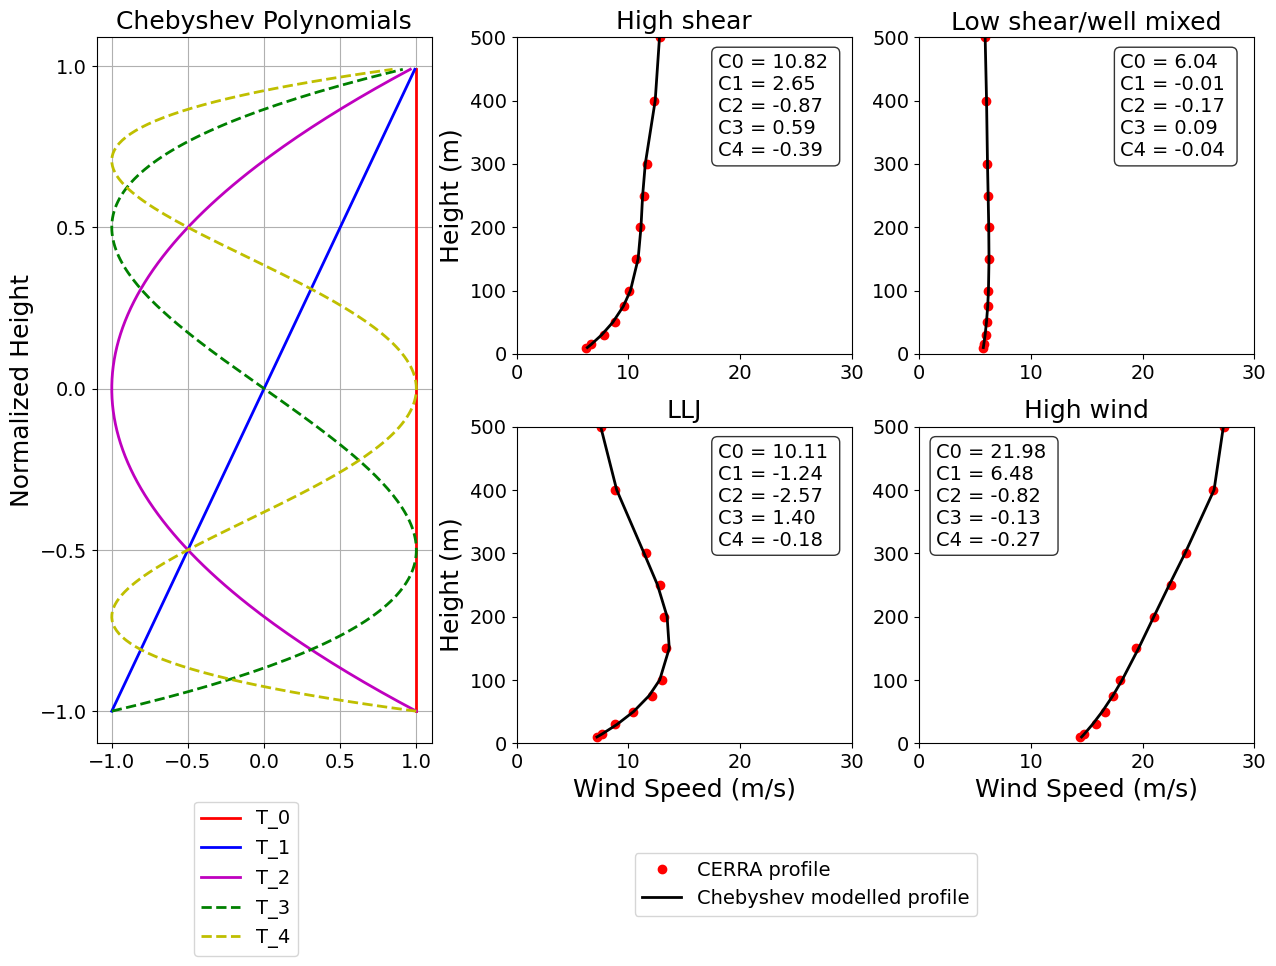

In [9]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fig.add_gridspec(2,4)
axs = chebyshev_polynomials_plotter(gs[0:2,0])
# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.15, -0.2),fontsize=14)
for k,profile in enumerate(profile_dates):
    i = np.where(ERA5.time.sel(time=slice(*dates_range)) == np.datetime64(profile_dates[profile][0]))[0][0]
    col = (k%2)+1
    row = k//2
    xlabel = 'Wind Speed (m/s)' if row == 1 else None
    ylabel = 'Height (m)' if col == 1 else None
    legend = None
    axs = profle_plotter_(gs[row,col],i,profile,xlabel=xlabel,ylabel=ylabel,legend=legend,text_loc=text_locs[k])
# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.15),fontsize=14)
plt.savefig(f'{FIG_DIR}/chebyshev_polynomials_and_vertical_profiles.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

In [10]:
def data_processing(input_variables,target_variables, dates_range, locations,val_arg=None):
    ERA5 = xr.open_dataset(f'data/ERA5.nc')
    ChSh_Coeff = xr.open_dataset(f'data/Chebyshev_Coefficnents.nc')

    if val_arg:
        #=== Extracting training and validation indices ===# 
        time_coord = ERA5.sel(time=slice(*dates_range)).coords['time']
        years = time_coord.dt.year
        months = time_coord.dt.month
        validation_times = np.zeros(len(time_coord), dtype=bool)
        for year in np.unique(years):
            for month in range(1, 13):
                month_indices = np.where((years == year) & (months == month))[0]
                if len(month_indices) >= 144:
                    start_index = np.random.choice(len(month_indices) - 143)
                    validation_indices = month_indices[start_index:start_index + 144]
                    validation_times[validation_indices] = True
        
        #=== Finish Extracting training and validation indices ===# 
        X_train = np.empty((0, len(input_variables)))
        Y_train = np.empty((0, len(target_variables)))
        X_valid = np.empty((0, len(input_variables)))
        Y_valid = np.empty((0, len(target_variables)))
    
        for loc in locations:
            # --- training ---#
            X_loc = ERA5[input_variables].sel(time=slice(*dates_range)).sel(time=~validation_times, location=loc).to_array().values.T
            X_train = np.concatenate((X_train, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range)).sel(coeff=target_variables,time=~validation_times, obs=loc).to_array().values
            Y_train = np.concatenate((Y_train, Y_loc[0,:,:]), axis=0)
    
            # --- vlaidation ---#
            X_loc = ERA5[input_variables].sel(time=slice(*dates_range)).sel(time=validation_times, location=loc).to_array().values.T
            X_valid = np.concatenate((X_valid, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range)).sel(coeff=target_variables,time=validation_times, obs=loc).to_array().values
            Y_valid = np.concatenate((Y_valid, Y_loc[0,:,:]), axis=0)        
    
        # Replace NaN values with zeros
        X_train = np.nan_to_num(X_train)
        Y_train = np.nan_to_num(Y_train)
        X_valid = np.nan_to_num(X_valid)
        Y_valid = np.nan_to_num(Y_valid)
        
        return X_train, Y_train, X_valid, Y_valid

    else:
        X = np.empty((0, len(input_variables)))
        Y = np.empty((0, len(target_variables)))

        for loc in locations:
            # --- testing ---#
            X_loc = ERA5[input_variables].sel(time=slice(*dates_range)).sel(location=loc).to_array().values.T
            X = np.concatenate((X, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range)).sel(coeff=target_variables, obs=loc).to_array().values
            Y = np.concatenate((Y, Y_loc[0,:,:]), axis=0)

        # Replace NaN values with zeros
        X = np.nan_to_num(X)
        Y = np.nan_to_num(Y)

        return X, Y

In [11]:
# === testing data parameters ===#
target_variables = [0,1,2,3,4]
X_test,Y_test = data_processing(input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (8760, 34) testing targets shape: (8760, 5)


In [12]:
def hexbin_plotter(gs,Y,pred,title,text_arg=None,xlabel_arg=None,ylabel_arg=None):
    errMAE    = mae(Y,pred)
    errRMSE   = np.sqrt(mse(Y,pred))
    errMAPE   = mape(Y,pred)
    errR2     = R2(Y,pred)

    ax_hexbin = fig.add_subplot(gs)
    hb = ax_hexbin.hexbin(np.squeeze(Y), np.squeeze(pred), gridsize=100, bins='log', cmap='inferno')
    if text_arg:
        ax_hexbin.text(0.05, 0.93, f'MAE: {errMAE:.2f} \n$R^2$: {errR2:.2f}\nRMSE: {errRMSE:.2f}',
                      transform=ax_hexbin.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if xlabel_arg:
        ax_hexbin.set_xlabel(f'CERRA coefficient',fontsize=14)
    if ylabel_arg:
        ax_hexbin.set_ylabel(f'TabNet coefficient',fontsize=14)
    ax_hexbin.set_title(f'{title}',fontsize=14)
    ax_hexbin.tick_params(labelsize=14)

    min_value = Y.min()
    max_value = Y.max()
    ax_hexbin.set_xlim(min_value, max_value+1)
    ax_hexbin.set_ylim(min_value, max_value+1)

In [13]:
nELI5max = 1 #FIXME
def myELI5(model,X,y,multiout=None,target_variable=None):
    
    nSamples, nFeatures = np.shape(X)
    iTot = np.arange(0,nSamples,1)
    
    #Original prediction
    if multiout:
        y_pred_org = model.predict(X)[:,target_variable]
    else:
        y_pred_org = model.predict(X)
    E_org      = np.sqrt(mse(y,y_pred_org)) 
    
    featImp = np.zeros(nFeatures)
    for nF in range(nFeatures):

        E_shfl_tot = 0
        for nELI5 in range(nELI5max):
            
            X_shfl = np.copy(X)

            np.random.shuffle(iTot)

            dum          = X_shfl[:,nF]
            X_shfl[:,nF] = dum[iTot]
            X_shfl       = pd.DataFrame(data=X_shfl)
            if multiout:
                y_pred_shfl  = model.predict(X_shfl.values)[:,target_variable]
            else:
                y_pred_shfl  = model.predict(X_shfl.values)
            E_shfl       = np.sqrt(mse(y,y_pred_shfl))

            E_shfl_tot   = E_shfl_tot + E_shfl

        #print(nF,E_org,E_shfl_tot/nELI5/E_org)
        featImp[nF] = (E_shfl_tot/nELI5max - E_org)*100/E_org
        
    return featImp

In [14]:
def feat_imp_plotter(gs,input_variables,featImp,title,color,xticklabels=None):
    ax = fig.add_subplot(gs)
    ax.bar(input_variables,featImp,color=color)
    ax.set_title(title)
    ax.set_ylabel('Score',fontsize=14)
    if xticklabels:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(input_variables,rotation='vertical',fontsize=14)
    else:
        ax.set_xticklabels('')

In [15]:
def feat_imp_plotter_H(gs,input_variables,featImp,title,color,yticklabels=None):
    ax = fig.add_subplot(gs)
    ax.barh(input_variables,featImp,color=color)
    ax.set_title(title)
    ax.set_xlabel('Score')
    if yticklabels:
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(input_variables,fontsize=12)
    else:
        ax.set_yticklabels('')

In [16]:
input_variables_ = [
    r'$\mathbf{W}_{10}$',
    r'$\mathbf{W}_{100}$',
    r'$\mathbf{\alpha}$',
    r'$\mathbf{W}_{975}$',
    r'$\mathbf{W}_{950}$',
    r'$\Delta \mathbf{W}_{975-100}$',
    r'$\Delta \mathbf{W}_{950-975}$',
    r'$\mathbf{u}_*$',
    r'$\mathbf{W}_{p10}^i$',
    r'$T_2$',
    r'$T_0$',
    r'$T_s$',
    r'$T_{d2}$',
    r'$P_0$',
    r'$\mathbf{H}$',
    r'$h_{cb}$',
    r'$H_S$',
    r'$H_L$',
    r'TCC',
    r'LCC',
    r'CAPE',
    r'CIN',
    r'$\bar{\epsilon}$',
    r'$T_{975}$',
    r'$T_{950}$',
    r'$\Delta T_1$',
    r'$\Delta T_2$',
    r'$\Delta T_3$',
    r'$\Delta T_4$',
    r'$\Delta T_5$',
    r'HRSin',
    r'HRCos',
    r'DYSin',
    r'DYCos']
input_variables_ 

['$\\mathbf{W}_{10}$',
 '$\\mathbf{W}_{100}$',
 '$\\mathbf{\\alpha}$',
 '$\\mathbf{W}_{975}$',
 '$\\mathbf{W}_{950}$',
 '$\\Delta \\mathbf{W}_{975-100}$',
 '$\\Delta \\mathbf{W}_{950-975}$',
 '$\\mathbf{u}_*$',
 '$\\mathbf{W}_{p10}^i$',
 '$T_2$',
 '$T_0$',
 '$T_s$',
 '$T_{d2}$',
 '$P_0$',
 '$\\mathbf{H}$',
 '$h_{cb}$',
 '$H_S$',
 '$H_L$',
 'TCC',
 'LCC',
 'CAPE',
 'CIN',
 '$\\bar{\\epsilon}$',
 '$T_{975}$',
 '$T_{950}$',
 '$\\Delta T_1$',
 '$\\Delta T_2$',
 '$\\Delta T_3$',
 '$\\Delta T_4$',
 '$\\Delta T_5$',
 'HRSin',
 'HRCos',
 'DYSin',
 'DYCos']

testing inputs shape: (8760, 34) testing targets shape: (8760, 5)


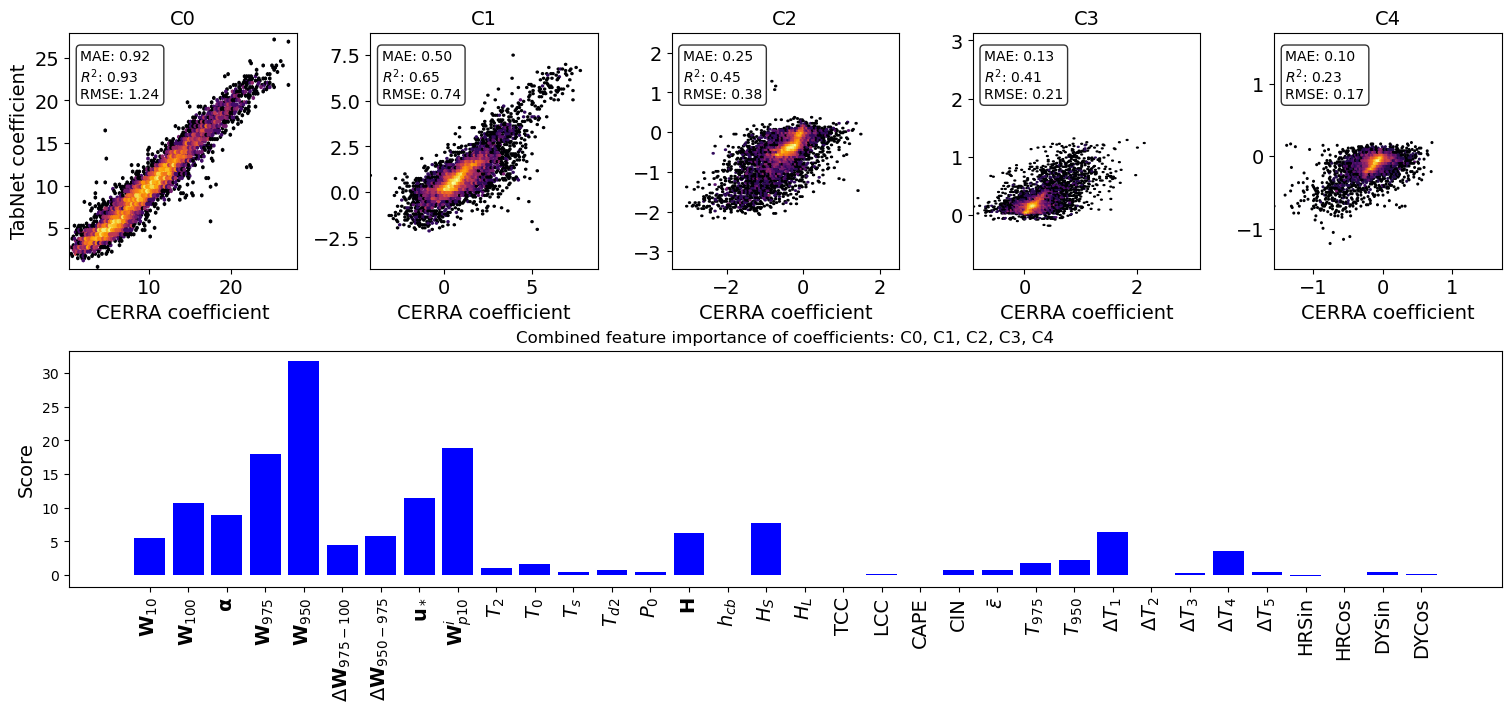

In [17]:
# === Plotter for multioutput training ===#
fig = plt.figure(figsize=(15, 7), constrained_layout=True)
gs = fig.add_gridspec(2,5)
Ens = 4  # For plotting sample hexbin plots
X_test,Y_test = data_processing(input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)            
OUTPUT_DIR = f'trained_models/models_8th_set/Ens_{Ens}'
# --- load normalizer ---#
min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')
Y_test_trans = min_max_scaler.transform(Y_test)
fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)
    Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
    for j,target_variable in enumerate(target_variables):
        ylabel_arg = True if j == 0 else False
        xlabel_arg = True
        hexbin_plotter(gs[0,j],Y_test[:,target_variable],Y_pred[:,target_variable],
                       f'C{target_variable}',
                       #f'C{target_variable},[{tabReg.n_d},{tabReg.n_steps},{tabReg.n_independent},{tabReg.n_shared},{tabReg.gamma}]',
                       text_arg=True,xlabel_arg=xlabel_arg,ylabel_arg=ylabel_arg)     

featImp = []
X_test,Y_test = data_processing(input_variables,target_variables,test_dates_range,test_locations)
for Ens in range(10):           
    OUTPUT_DIR = f'trained_models/models_8th_set/Ens_{Ens}'
    # --- load normalizer ---#
    min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')
    Y_test_trans = min_max_scaler.transform(Y_test)
    fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
    with open(fSTR, "rb") as f:
        tabReg = pickle.load(f)    
    # --- feat imp ---#
    featImp.append(myELI5(tabReg,X_test,Y_test_trans))

feat_imp_plotter(gs[1,:],input_variables_,np.array(featImp).mean(axis=0),
    f"Combined feature importance of coefficients: {', '.join([f'C{i}' for i in target_variables])}",'blue',xticklabels=True)
plt.savefig(f'{FIG_DIR}/Tabnet_multi_output_hexbins_feature_importance.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

In [18]:
def profle_plotter(gs,i,title,xlabel=None,ylabel=None,text_loc=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[i,0:2]
    axs.plot(ERA5_ws, [10.0,100.0], 'dg', markerfacecolor='g', label='ERA5')

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[i, :])
    axs.plot(M_true, Z, 'or', markerfacecolor='r', label='CERRA')

    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'trained_models/models_8th_set/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test[i:i+1,:]))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
    p95_profile = np.percentile(ensemble_predictions, 90, axis=0)

    # Plot median
    axs.plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    axs.fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])
    axs.set_title(title)

    axs.set_xlabel(xlabel)
    if ylabel:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    if text_loc:
        errMAE    = mae(M_true,median_profile)
        errRMSE   = np.sqrt(mse(M_true,median_profile))
        errMAPE   = mape(M_true,median_profile)*100
        axs.text(text_loc[0], text_loc[1], f'RMSE: {errRMSE:0.2f} m/s\nMAPE: {errMAPE:.1f}%',
                      transform=axs.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),fontsize=12)

    return axs

In [19]:
text_locs = [[0.45, 0.2],[0.45, 0.2],[0.45, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

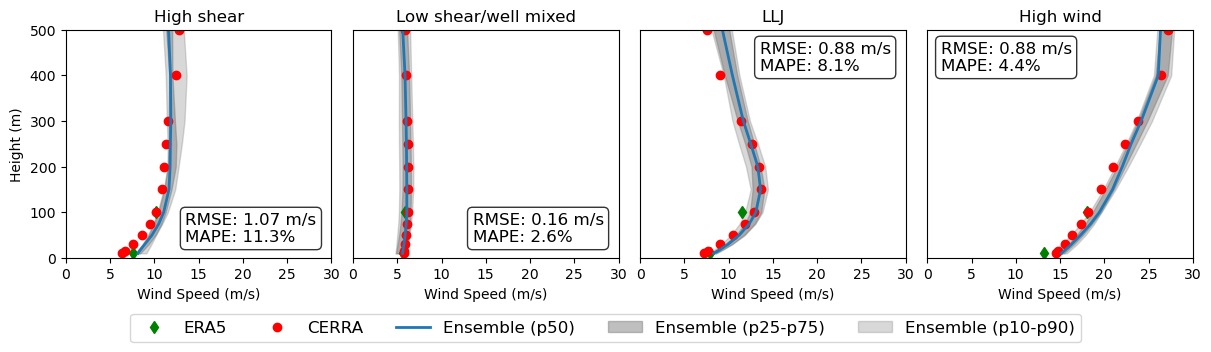

In [20]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
for k,profile in enumerate(profile_dates):
    i = np.where(ERA5.time.sel(time=slice(*dates_range)) == np.datetime64(profile_dates[profile][0]))[0][0]
    ylabel = 'Height (m)' if k == 0 else None
    axs = profle_plotter(gs[k],i,profile,xlabel='Wind Speed (m/s)',ylabel=ylabel,text_loc=text_locs[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)
plt.savefig(f'{FIG_DIR}/Tabnet_multi_output_best_wind_profiles.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

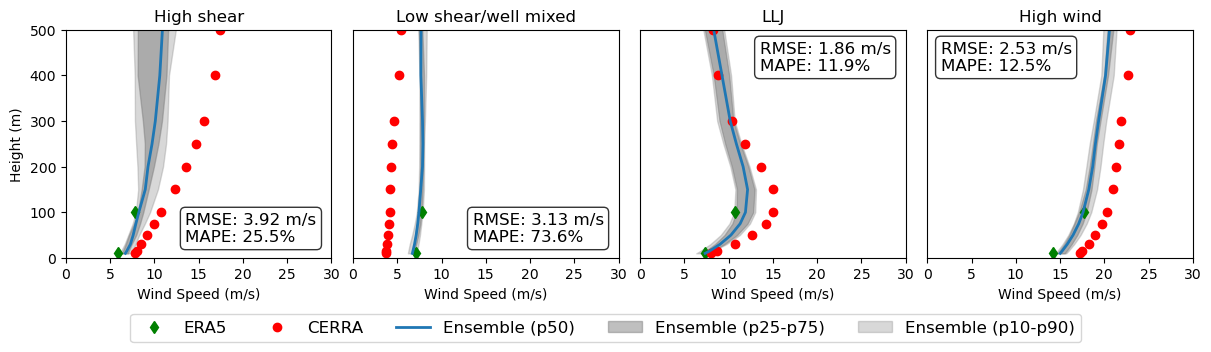

In [21]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
for k,profile in enumerate(profile_dates):
    i = np.where(ERA5.time.sel(time=slice(*dates_range)) == np.datetime64(profile_dates[profile][1]))[0][0]
    ylabel = 'Height (m)' if k == 0 else None
    axs = profle_plotter(gs[k],i,profile,xlabel='Wind Speed (m/s)',ylabel=ylabel,text_loc=text_locs[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)
plt.savefig(f'{FIG_DIR}/Tabnet_multi_output_worst_wind_profiles.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

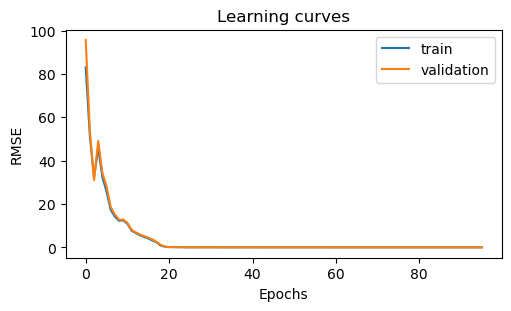

In [22]:
# --- Plot loss curve and hexbin ---
fig = plt.figure(figsize=(5, 3), constrained_layout=True)
gs = fig.add_gridspec(1,1)

Ens = 4
OUTPUT_DIR = f'trained_models/models_8th_set/Ens_{Ens}'
# Load model
fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)
# Line plot for train and validation RMSE
ax = fig.add_subplot(gs[0])
ax.plot(tabReg.history['train_rmse'], label='train')
ax.plot(tabReg.history['valid_rmse'], label='validation')
ax.set_title('Learning curves')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.legend()
plt.savefig(f'{FIG_DIR}/Learning_curves.pdf',dpi=300,bbox_inches='tight',pad_inches=0)